In [2]:
import torch
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import LinAlgError

In [4]:
def check_transformation_matrix(M: torch.Tensor) -> bool:
    """
    Validates a 3x3 matrix (torch.Tensor) representing an affine transformation on R^2.

    Checks:
    1. Affine on R^2: last row is [0, 0, 1]
    2. Contraction: largest singular value of A < 1
    3. Invertibility: det(M) != 0
    4. Fixed point in [0, 1]^2

    Args:
        M (torch.Tensor): 3x3 matrix

    Returns:
        bool: True if valid, False otherwise
    """
    if not isinstance(M, torch.Tensor) or M.shape != (3, 3):
        raise ValueError("Input must be a 3x3 torch.Tensor.")

    # 1. Affine check
    if not torch.allclose(M[2, :], torch.tensor([0.0, 0.0, 1.0], dtype=M.dtype, device=M.device)):
        return False

    # 2. Contraction check
    A = M[:2, :2]
    try:
        singular_values = torch.linalg.svdvals(A)
    except Exception:
        return False
    if torch.max(singular_values) >= 1.0:
        return False

    # 3. Invertibility
    if torch.isclose(torch.det(M), torch.tensor(0.0, dtype=M.dtype, device=M.device)):
        return False

    # 4. Fixed point in [0, 1]^2
    I = torch.eye(2, dtype=M.dtype, device=M.device)
    b = M[:2, 2]
    try:
        fixed_point = torch.linalg.solve(A - I, -b)
    except Exception:
        return False
    x, y = fixed_point.tolist()
    if not (0 <= x <= 1 and 0 <= y <= 1):
        return False

    return True

In [17]:
class FixedMeasure:
    """
    Computes the fixed measure of an Iterated Function System (IFS) for a given
    initial measure using the Banach fixed-point theorem.
    This version is optimized for GPU (CUDA) execution if available.
    """
    def __init__(self, F: List[torch.Tensor], nu: torch.Tensor, p: torch.Tensor = None, eps: float = 1e-4):
        """
        Initializes the FixedMeasure system.

        Args:
            F (List[torch.Tensor]): A list of 3x3 invertible matrices representing the
                                     affine transformations f(x) = Ax + b.
            nu (torch.Tensor): The initial measure on a d x d pixel grid of the unit square.
            p (torch.Tensor, optional): A probability vector of length n. Defaults to uniform.
            eps (float): The convergence threshold for the Wasserstein-infinity distance.
        """

        # --- Validation (on CPU) ---
        if not all(check_transformation_matrix(f) for f in F):
            raise ValueError("All transformations in F must be valid IFS maps.")
        if not torch.isclose(p.sum(), torch.tensor(1.0, dtype=p.dtype, device=p.device)):
            raise ValueError("Probability vector p must sum to 1.")
        
        # Set the computation device to CUDA if available, otherwise CPU.
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        torch.set_default_dtype(torch.float32)

        # Move input matrices to the selected device
        self.F = [m.to(torch.float32).to(self.device) for m in F]
        self.n = len(F)
        self.eps = eps

        if p is None:
            # Default to a uniform probability vector if not provided
            self.p = torch.full((self.n,), 1.0 / self.n, dtype=torch.float32, device=self.device)
        else:
            assert p.shape[0] == self.n, f"Probability vector p must have length {self.n}."
            assert abs(p.sum().item() - 1.0) < 1e-6, "Probabilities in p must sum to 1."
            self.p = p.to(torch.float32).to(self.device)
        
        # The measure nu is defined on a d x d grid
        assert nu.dim() == 2 and nu.shape[0] == nu.shape[1], "nu must be a square tensor."
        self.d = nu.shape[0]

        # Raise an error if d is not a power of 2
        if not (self.d & (self.d - 1) == 0 and self.d != 0):
            raise ValueError(f"d = {self.d} is not a power of 2. Please use a power-of-2 grid size.")

        # Reshape initial measure for grid_sample (N, C, H, W), normalize, and move to device
        self.mu = nu.reshape(1, 1, self.d, self.d).to(self.device)
        self.mu = self.mu / self.mu.sum()

        # Precompute transformed grids and Jacobians on the selected device
        self.Maps = self._precompute_maps()

    def _precompute_maps(self) -> List[Tuple[torch.Tensor, float]]:
        """
        Precomputes the transformed sampling grids and Jacobian determinants for each map.
        This is a one-time setup cost to accelerate the iterative solve method.

        Returns:
            List[Tuple[torch.Tensor, float]]: A list where each element is a tuple containing
                                              the transformed grid for grid_sample and the
                                              absolute Jacobian determinant.
        """
        maps_data = []

        # Create a base grid of coordinates on the selected device.
        y_coords = torch.linspace(0, 1, self.d, dtype=torch.float32, device=self.device)
        x_coords = torch.linspace(0, 1, self.d, dtype=torch.float32, device=self.device)
        grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')
        
        grid_flat = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)
        grid_homogeneous = torch.cat([grid_flat, torch.ones(self.d * self.d, 1, device=self.device)], dim=1)

        for f_matrix in self.F:
            A = f_matrix[:2, :2]
            jac_det = torch.det(A).abs().item()

            f_inv = torch.inverse(f_matrix)
            transformed_homogeneous = torch.matmul(grid_homogeneous, f_inv.t())
            transformed_flat = transformed_homogeneous[:, :2] / transformed_homogeneous[:, 2].unsqueeze(1)

            normalized_transformed_grid = 2 * transformed_flat - 1
            final_grid = normalized_transformed_grid.reshape(1, self.d, self.d, 2)
            
            maps_data.append((final_grid, jac_det))
            
        return maps_data

    def push_forward(self, mu: torch.Tensor) -> torch.Tensor:
        """
        Computes the weighted push-forward measure: mu_{t+1} = Σ p_i * f_i#(mu_t).

        Args:
            mu (torch.Tensor): Current measure, shape (1, 1, d, d).

        Returns:
            torch.Tensor: The next measure in the iteration.
        """
        mu_next = torch.zeros_like(mu, device=self.device)

        for i, (transformed_grid, jac_det) in enumerate(self.Maps):
            pushed_mu_component = torch.nn.functional.grid_sample(
                mu,
                transformed_grid,
                mode='bilinear',
                padding_mode='zeros',
                align_corners=True
            )

            if jac_det > 1e-9:
                pushed_mu_component /= jac_det
            
            # Weight the pushforward component by its probability
            mu_next += self.p[i] * pushed_mu_component
        
        # Re-normalize to counteract any minor mass loss from interpolation/padding
        mu_next /= mu_next.sum()
        
        return mu_next

    def wasserstein_inf(self, mu1: torch.Tensor, mu2: torch.Tensor) -> float:
        """
        Computes an approximation of the Wasserstein-infinity distance.

        Args:
            mu1, mu2 (torch.Tensor): The two measures to compare.

        Returns:
            float: The approximated W_infinity distance.
        """
        return torch.abs(mu1 - mu2).max().item()

    def solve(self, max_iterations: int = 1000, min_iterations: int = 100) -> torch.Tensor:
        """
        Iterates the pushforward operation until the measure converges to a fixed point.

        Args:
            max_iterations (int): Maximum number of iterations to perform.
            min_iterations (int): Minimum number of iterations before checking for convergence.

        Returns:
            torch.Tensor: The final, converged measure.
        """
        current_mu = self.mu.clone()
        
        for t in range(max_iterations):
            next_mu = self.push_forward(current_mu)
            w_inf = self.wasserstein_inf(current_mu, next_mu)
            
            print(f"Iteration {t+1}, W_infinity = {w_inf:.2e}")
            
            if abs(next_mu.sum().item() - 1.0) > 1e-9:
                print(f"Warning: Measure not properly normalized. Total mass = {next_mu.sum().item()}")

            if t + 1 >= min_iterations and w_inf < self.eps:
                print(f"Converged after {t+1} iterations!")
                return next_mu
            
            current_mu = next_mu
        else:
            print(f"Maximum iterations ({max_iterations}) reached. Final W_infinity = {w_inf:.2e}")
            
        return current_mu
        
    def visualize_measure(self, mu: torch.Tensor, title: str = "Measure Visualization"):
        """
        Visualize the measure as a heatmap.

        Args:
            mu (torch.Tensor): The measure to visualize (tensor on self.device).
            title (str): Title for the plot.
        """
        # Move the measure to the CPU and convert to a numpy array for plotting
        mu_np = mu.cpu().squeeze().numpy()

        plt.figure(figsize=(10, 10))
        # The extent is the unit square [0, 1] x [0, 1].
        # Using 'gray_r' colormap for a traditional black-on-white fractal.
        plt.imshow(mu_np, origin='lower', extent=[0, 1, 0, 1], cmap='gray_r')
        plt.colorbar(label='Measure Density')
        plt.title(title)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

Using device: cuda
Iteration 1, W_infinity = 9.54e-07
Iteration 2, W_infinity = 1.27e-06
Iteration 3, W_infinity = 1.70e-06
Iteration 4, W_infinity = 2.26e-06
Iteration 5, W_infinity = 3.01e-06
Iteration 6, W_infinity = 4.02e-06
Iteration 7, W_infinity = 5.36e-06
Iteration 8, W_infinity = 7.14e-06
Iteration 9, W_infinity = 9.53e-06
Iteration 10, W_infinity = 1.27e-05
Iteration 11, W_infinity = 2.89e-09
Iteration 12, W_infinity = 2.92e-09
Iteration 13, W_infinity = 2.94e-09
Iteration 14, W_infinity = 2.94e-09
Iteration 15, W_infinity = 2.95e-09
Iteration 16, W_infinity = 2.95e-09
Iteration 17, W_infinity = 2.95e-09
Iteration 18, W_infinity = 2.95e-09
Iteration 19, W_infinity = 2.95e-09
Iteration 20, W_infinity = 2.95e-09
Iteration 21, W_infinity = 2.95e-09
Iteration 22, W_infinity = 2.95e-09
Iteration 23, W_infinity = 2.95e-09
Iteration 24, W_infinity = 2.95e-09
Iteration 25, W_infinity = 2.95e-09
Iteration 26, W_infinity = 2.95e-09
Iteration 27, W_infinity = 2.95e-09
Iteration 28, W_in

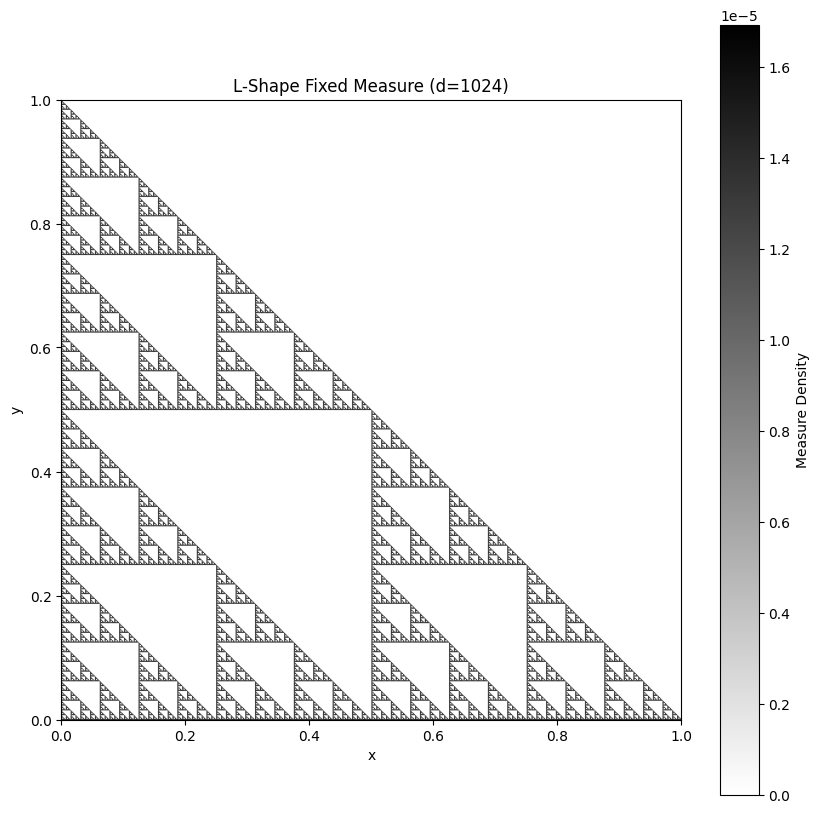

In [19]:
# --- Example Usage ---
if __name__ == "__main__":
    # Define the affine transformations for the L-Shape fractal
    sierpinski_matrices = [
        torch.tensor([
            [0.5, 0.0, 0.0],
            [0.0, 0.5, 0.0],
            [0.0, 0.0, 1.0]
        ]),
        torch.tensor([
            [0.5, 0.0, 0.5],
            [0.0, 0.5, 0.0],
            [0.0, 0.0, 1.0]
        ]),
        torch.tensor([
            [0.5, 0.0, 0.0],
            [0.0, 0.5, 0.5],
            [0.0, 0.0, 1.0]
        ])
    ]
    
    # Define the probability vector (uniform for this example)
    p_vector = torch.tensor([1/3, 1/3, 1/3])

    # Define the grid resolution and the initial measure (uniform)
    d_resolution = 1024
    initial_nu = torch.ones((d_resolution, d_resolution))

    # Create the FixedMeasure instance
    sierpinski_ifs = FixedMeasure(F=sierpinski_matrices, nu=initial_nu, p=p_vector, eps=1e-7)

    # Solve for the fixed measure, running at least 100 iterations
    final_sierpinski_measure = sierpinski_ifs.solve(max_iterations=200, min_iterations=50)

    # Visualize the final measure
    sierpinski_ifs.visualize_measure(
        final_sierpinski_measure,
        title=f"L-Shape Fixed Measure (d={d_resolution})"
    )

In [3]:
torch.cuda.is_available()

True